In [60]:
import torch
import torchquantum as tq
import torchquantum.functional as tqf
import numpy as np
import matplotlib.pyplot as plt

In [61]:
# 2. 修正量子电路实现
class QuantumSolver(tq.QuantumModule):
    def __init__(self, n_wires=4, n_layers=2):
        super().__init__()
        self.n_wires = n_wires
        self.n_layers = n_layers
        
        # 可训练参数
        self.gamma = torch.nn.Parameter(torch.rand(n_layers))
        self.beta = torch.nn.Parameter(torch.rand(n_layers))
        
    def forward(self, qubo_matrix):
        # 将QUBO矩阵转换为对角哈密顿量
        diag_terms = torch.diag(torch.tensor(qubo_matrix, dtype=torch.float32))
        
        # 初始化量子设备（使用状态向量模拟器）
        self.q_device = tq.QuantumDevice(n_wires=self.n_wires, bsz=1, record_op=True)
        
        # 初始化叠加态
        for wire in range(self.n_wires):
            tqf.hadamard(self.q_device, wires=wire)
        
        # 构建QAOA层
        for layer in range(self.n_layers):
            # Cost层：应用RZ门模拟对角哈密顿量
            for wire in range(self.n_wires):
                tqf.rz(self.q_device, wires=wire, params=self.gamma[layer]*diag_terms[wire])
            
            # Mixer层：应用RX门
            for wire in range(self.n_wires):
                tqf.rx(self.q_device, wires=wire, params=self.beta[layer])
        
        # 获取最终状态向量
        state = self.q_device.get_states_1d()
        
        # 修正能量计算：将状态概率与基态能量对应
        prob = torch.abs(state)**2
        basis_energies = torch.tensor([sum([diag_terms[i] * ((idx >> i) & 1) 
                                     for i in range(self.n_wires)])
                                     for idx in range(2**self.n_wires)])
        energy = torch.sum(prob * basis_energies)
        return energy

In [62]:
# 3. 评估函数
def evaluate_algorithm(qubo_matrix, n_epochs=500):
    model = QuantumSolver(n_wires=qubo_matrix.shape[0])
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    
    energies = []
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        energy = model(qubo_matrix)
        (-energy).backward()
        optimizer.step()
        energies.append(energy.item())
    
    plt.figure(figsize=(8,4))
    plt.plot(energies)
    plt.title('Optimization Trajectory')
    plt.xlabel('Epoch')
    plt.ylabel('Energy')
    plt.show()
    
    min_energy = np.min(np.diag(qubo_matrix))
    return np.exp(-(energies[-1] - min_energy))

In [63]:
def generate_ncRNA_qubo(size=6):
    Q = np.array([
        [-124, 88, 0, 44,0,0],
        [88, -124, 88, 0,44,0],
        [0, 88, -124,88,0,44],
        [44, 0, 88, -124,88,0],
        [0, 44, 0, 88,-124,88],
        [0, 0, 44, 0,88,-124]
    ], dtype=np.float32)
    return Q

def generate_RSA_qubo(size=6):
    Q = np.array([
        [-128, 0, 0, 64,64,64],
        [0, -128, 0, 64,64,64],
        [0, 0, -128, 0,0,0],
        [0, 0, 0, -128,0,0],
        [64, 64, 64, 0,-128,0],
        [64, 64, 64, 0,0,-128]
    ], dtype=np.float32)
    return Q

def generate_AES_qubo(size=6):
    Q = np.array([
        [-96, 32, 0, 0,0, 0],
        [32, -96, 0, 0,0, 0],
        [0, 0, -96, 32,0, 0],
        [0, 0, 32, -96,0, 0],
        [0, 0, 0, 0,-96, 32],
        [0, 0, 0, 0,32, -96]
    ], dtype=np.float32)
    return Q

Generating QUBO matrices...

Evaluating Crypto-ncRNA...


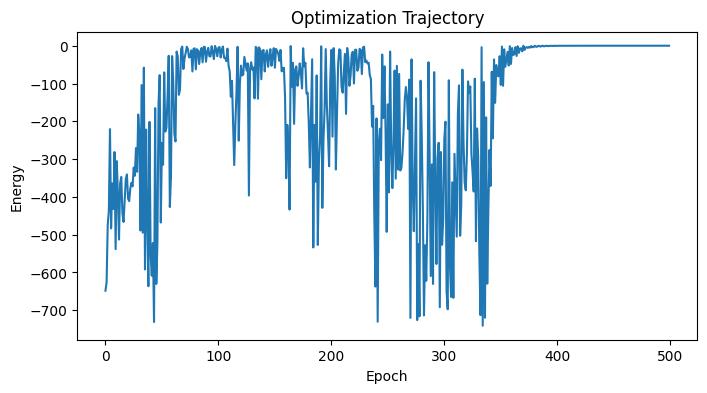


Evaluating RSA...


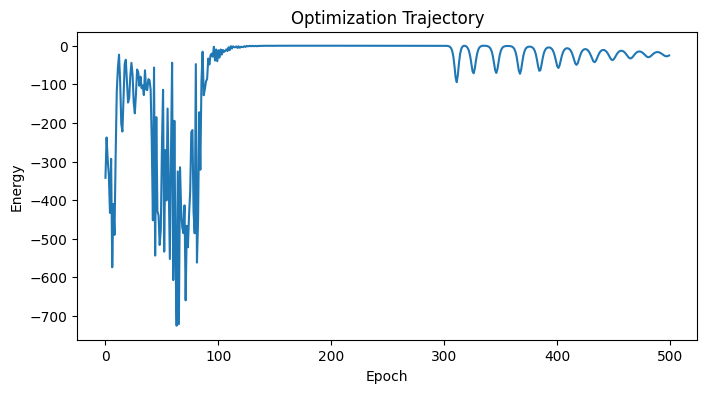


Evaluating AES...


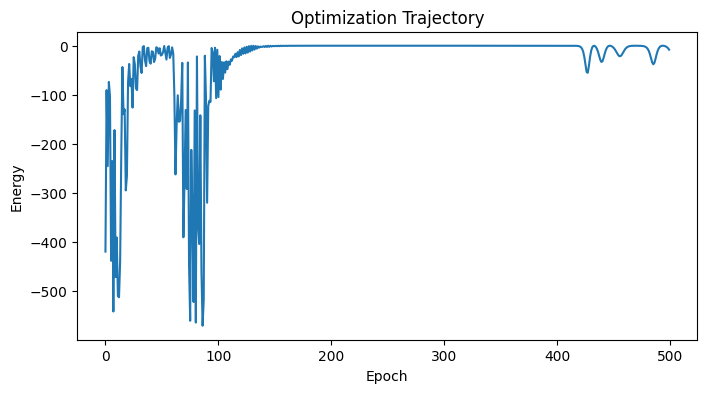

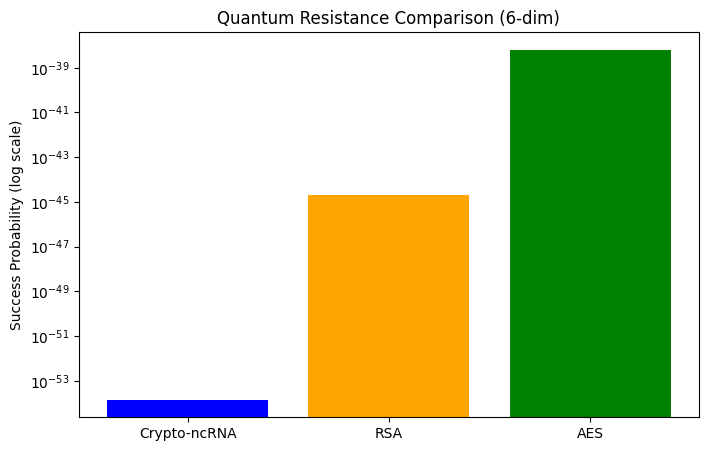

In [64]:
# 4. 主测试流程
if __name__ == "__main__":
    print("Generating QUBO matrices...")
    qubo_ncRNA = generate_ncRNA_qubo()
    qubo_RSA = generate_RSA_qubo()
    qubo_AES = generate_AES_qubo()
    
    print("\nEvaluating Crypto-ncRNA...")
    prob_ncRNA = evaluate_algorithm(qubo_ncRNA)
    
    print("\nEvaluating RSA...")
    prob_RSA = evaluate_algorithm(qubo_RSA)
    
    print("\nEvaluating AES...")
    prob_AES = evaluate_algorithm(qubo_AES)
    
    # 显示结果
    results = {
        'Crypto-ncRNA': prob_ncRNA,
        'RSA': prob_RSA,
        'AES': prob_AES
    }
    
    plt.figure(figsize=(8,5))
    plt.bar(results.keys(), results.values(), color=['blue', 'orange', 'green'])
    plt.yscale('log')
    plt.ylabel('Success Probability (log scale)')
    plt.title('Quantum Resistance Comparison (6-dim)')#越小越好
    plt.show()